# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [215]:
# Installing Libraries
# !pip install scikit-learn matplotlib Pillow

In [216]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

#Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss,classification_report,f1_score
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [217]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [218]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [291]:
# Loading the dataset
# eg.
dirpath1 = './dataset/IIIT-CFW/'
dirpath2 = './dataset/IMFDB/'
dirpath3 = './dataset/Yale_face_database/'
dirpath = [dirpath1,dirpath2,dirpath3]
X,y = load_data(dirpath1)
X1,y1 = load_data(dirpath1)
X2,y2 = load_data(dirpath2)
X3,y3 = load_data(dirpath3)
N,H,W = X.shape[0:3]
N1,H1,W1 = X1.shape[0:3]
N2,H2,W2 = X2.shape[0:3]
N3,H3,W3 = X3.shape[0:3]
C = 1 if opt['is_grayscale'] else X1.shape[3]

Dataset shape: (672, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


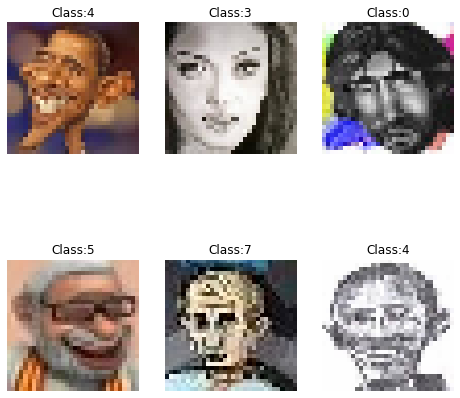

In [220]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [221]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [292]:
X1 = X1.reshape((N1,H1*W1*C))
X2 = X2.reshape((N2,H2*W2*C))
X3 = X3.reshape((N3,H3*W3*C))
X = np.array([X1,X2,X3])
y = np.array([y1,y2,y3])

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [223]:
def get_pca(X,k,reconstruct=False):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    if reconstruct:
        X_rec = pca.inverse_transform(X_k)
        return X_rec
    else:
        return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [224]:
def get_kernel_pca(X, k,kernel='rbf',reconstruct=False, degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    if reconstruct:
        X_rec = kpca.inverse_transform(X_k)
        return X_rec
    else:
        return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [225]:
def get_lda(X,y,X_test=None,k=40):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    if X_test is not None:
        X_1 = lda.transform(X_test)
        return X_k,X_1
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [226]:
def get_kernel_lda(X,y,X_test=None,k=40,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
        if X_test is not None:
            x_transformed = X_test**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
        if X_test is not None:
            x_transformed = np.exp(-X_test/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
        if X_test is not None:
            X_transformed = np.tanh(X_test)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X_transformed,y)
    if X_test is not None:
        X_1 = klda.transform(x_transformed)
        return X_k,X_1
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [227]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [228]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

 Eigenfaces are an orthogonal basis set from which most, or even all faces can be constructed. They are a set of eigenvectors when they are used in the computer vision problem of human face recognition. The word Eigenfaces is in analogy with eigenvalues and eigenvectors, which are an orthonormal basis sets to describe information. 

Specifically, the Eigenfaces are the principal components of a distribution of faces, or equivalently, the eigenvectors of the covariance matrix of the set of face images. The idea is that any face can be reconstructed from a suitable linear combination of eigenfaces.

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


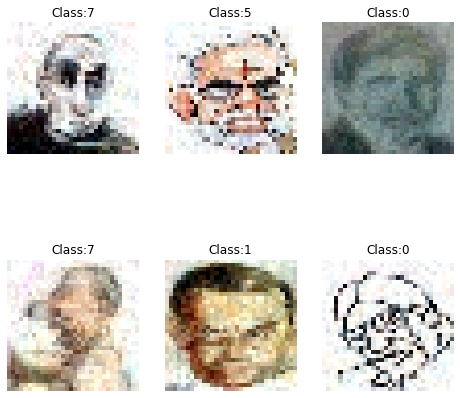

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


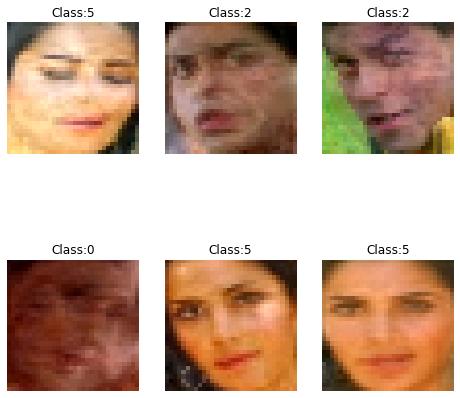

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


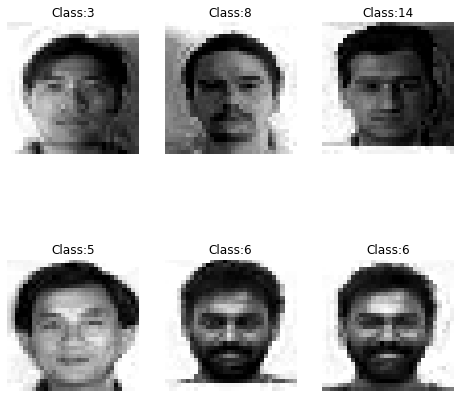

In [229]:
# Compute your features 
# eg.
k = [280,100,50]
for i in range(3):
    X_pca = get_pca(X[i].T,k[i],reconstruct=True).T
    X_pca = X_pca.reshape(X_pca.shape[0],H,W,C)
    ind = np.random.randint(0,y[i].shape[0],6)
    disply_images(X_pca[ind],y[i][ind], row=2,col=3)

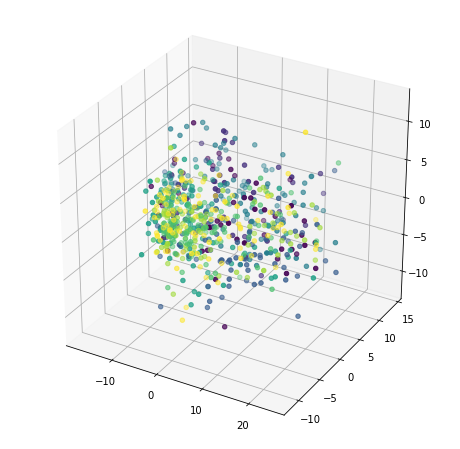

In [230]:
# Create a scatter plot  
# eg.
X_3D = get_pca(X1,3)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c = y1)

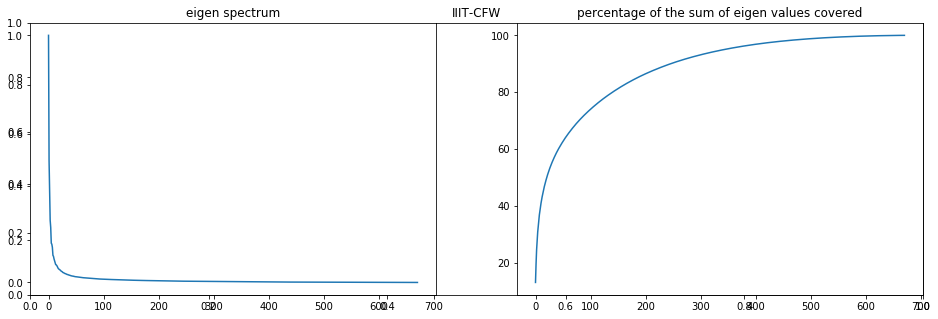

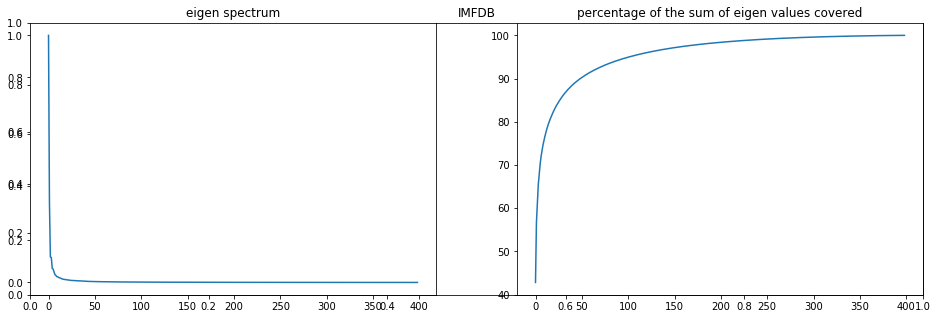

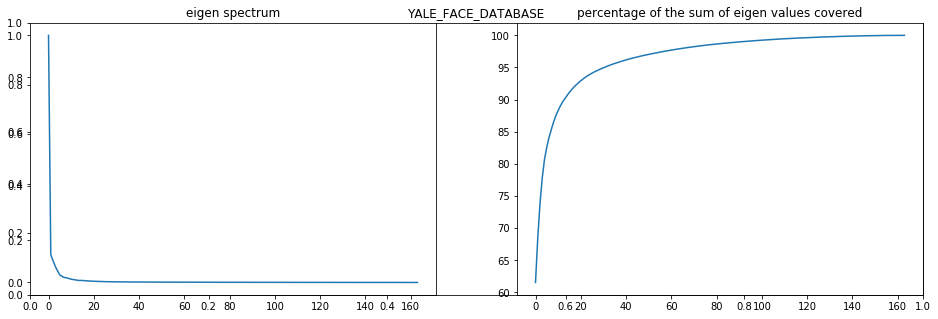

In [231]:
# Plot the eigen value spectrum 
def eig_spectrum(X,title):
    cov = np.cov(X)
    e,v = np.linalg.eigh(cov)
    e = e[-1:0:-1]

    fig = plt.figure(figsize=(16,5))
    plt.title(title)
    ax = fig.add_subplot(121)
    plt.title("eigen spectrum")
    plt.plot(e/e[0])
    e = np.cumsum(e)
    e = e*(100)/e[-1]
    ax = fig.add_subplot(122)
    plt.title("percentage of the sum of eigen values covered")
    plt.plot(e)
    plt.show()
    
eig_spectrum(X1,"IIIT-CFW")
eig_spectrum(X2,"IMFDB")
eig_spectrum(X3,"YALE_FACE_DATABASE")


1(c). Reconstruct  the  image  back for each case


In [232]:
def reconstruct_images(X,y,n):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    reconstruct_X = get_pca(X.T,n,reconstruct=True).T
    
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


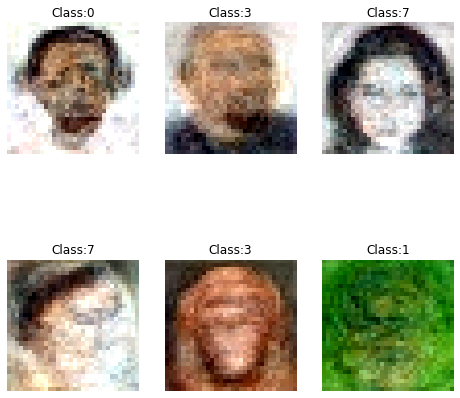

0.13662662543850276


In [293]:
# Display results 
X_reconstructed = reconstruct_images(X1,y1,100)
X_reconstructed = X_reconstructed.reshape((N1,H1,W1,C))
# Display random images
ind = np.random.randint(0,y2.shape[0],6)
disply_images(X_reconstructed[ind,:,:,:],y2[ind],row=2,col=3)

# Show the reconstruction error
X_reconstructed = X_reconstructed.reshape((N1,H1*W1*C))
print(np.sqrt(np.mean((X1 - X_reconstructed)**2)))

## 1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [294]:
# code goes here
def calc_worst_error(X,y,dictionary=None):
    X_reconstructed = reconstruct_images(X,y,100)
    cc = (((X-X_reconstructed)**2).mean(axis=1))
    cla = np.unique(y)
    worst,ma = 0,0
    for i in cla:
        ccc = cc[np.where(y==i)].mean()
#         print(i,ccc)
        if ccc > ma:
            worst,ma = i,ccc
    if dictionary is not None:
        print("Maximum mean reconstruction error is occuring for",list(dictionary.keys())[int(worst)],"with class-id",int(worst))
calc_worst_error(X1,y1,cfw_dict)
calc_worst_error(X2,y2,imfdb_dict)

Maximum mean reconstruction error is occuring for NarendraModi with class-id 5
Maximum mean reconstruction error is occuring for AkshayKumar with class-id 6


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [241]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self,clf="MLP",max_iter=400):
        self.classifier = None
        if clf == "MLP":
            self.classifier = MLPClassifier(hidden_layer_sizes=(256,128),max_iter=max_iter,random_state=2)
        elif clf == "Logistic_regression":
            self.classifier = LogisticRegression()
        elif clf=="SVM":
            self.classifier = SVC(kernel='linear',C = 0.2)
        elif clf=="Decision_tree":
            self.classifier = DecisionTreeClassifier()
            
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.classifier.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = confusion_matrix(y,pred)
        return cm
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classifier.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """

        # Create a confusion matrix
        pred = self.classify(X_validate)
        cm = self.confusion_matrix(pred,y_validate)
        # Calculate Validation accuracy 
        acc = accuracy_score(y_validate,pred)
        # Calculate precision and recall 
        rep = classification_report(y_validate,pred)
        # Calculate F1-score
        f1 = f1_score(y_validate,pred,average='weighted')
        return cm,acc,rep,f1

In [242]:
# Create a train and validation split to train your classifier
def split(X,y):
    return train_test_split(X,y,test_size = 0.2)


In [243]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)
def get_features(ind,i):
    if i==0:
        ft = get_pca(X[ind],40)
        return split(ft,y[ind])
    elif i==1:
        ft = get_kernel_pca(X[ind],40)
        return split(ft,y[ind])
    elif i==2:
        X_train,X_val,y_train,y_val = split(X[ind],y[ind])
        ft,ft1 = get_lda(X_train,y_train,X_val,40)
        return ft,ft1,y_train,y_val
    elif i==3:
        X_train,X_val,y_train,y_val = split(X[ind],y[ind])
        ft,ft1 = get_kernel_lda(X_train,y_train,X_val,40)
        return ft,ft1,y_train,y_val
    elif i==4:
        ft = get_vgg_features(dirpath[ind])
        return split(ft,y[ind])
    elif i==5:
        ft = get_resnet_features(dirpath[ind])
        return split(ft,y[ind])
    return ind,ind,ind,ind

def get_table(ind):
    models = ["MLP","Logistic_regression","SVM","Decision_tree"]
    class_error = []
    accuracy = []
    score = []
    con_matrix = []
    red_space = []
    cls_model = []
    for j in range(6):
        best_acc, best_con_matrix, best_score, mod = 0, 0, 0, 0
        for i in range(4):
            cls = Classifier(models[i])
            X_train,X_val,y_train,y_val = get_features(ind,j)
            cls.train(X_train,y_train)
            cm,acc,rep,f1 = cls.validate(X_val,y_val)
            if best_acc < acc:
                best_acc,best_con_matrix,best_score,mod = acc,cm,f1,models[i]
        con_matrix.append(best_con_matrix)
        score.append(best_score)
        accuracy.append(best_acc*100)
        class_error.append((1-best_acc)*100)
        red_space.append(X_train.shape[1])
        cls_model.append(mod)
        
    return accuracy,class_error,score,red_space,cls_model,con_matrix
conf_matrix = []
features = ["PCA","Kernel PCA","LDA","Kernel LDA","VGG features","RESNET features"]
print(dirpath[0])
accuracy,class_error,score,red_space,cls_model,con_matrix = get_table(0)
conf_matrix.append(con_matrix[np.argmax(accuracy)])
tab = {"Features":features,"Best_model":cls_model,"Reduced Dimension Space": red_space, "Classification_error": class_error,"Accuracy":accuracy,"f1-score":score}
df = pd.DataFrame(tab)
df

,Features,Best_model,Reduced Dimension Space,Classification_error,Accuracy,f1-score
0,PCA,Logistic_regression,40,42.222222,57.777778,0.578319
1,Kernel PCA,MLP,40,40.000000,60.000000,0.595213
2,LDA,SVM,7,55.555556,44.444444,0.448701
3,Kernel LDA,MLP,7,84.444444,15.555556,0.141682
4,VGG features,Logistic_regression,4096,29.629630,70.370370,0.691084
5,RESNET features,Logistic_regression,2048,0.740741,99.259259,0.992829


In [244]:
print(dirpath[1])
accuracy,class_error,score,red_space,cls_model,con_matrix = get_table(1)
conf_matrix.append(con_matrix[np.argmax(accuracy)])
tab = {"Features":features,"Best_model":cls_model,"Reduced Dimension Space": red_space, "Classification_error": class_error,"Accuracy":accuracy,"f1-score":score}
df = pd.DataFrame(tab)
df

,Features,Best_model,Reduced Dimension Space,Classification_error,Accuracy,f1-score
0,PCA,MLP,40,18.75,81.25,0.804934
1,Kernel PCA,MLP,40,30.00,70.00,0.700284
2,LDA,Logistic_regression,7,18.75,81.25,0.810743
3,Kernel LDA,Logistic_regression,7,41.25,58.75,0.597116
4,VGG features,SVM,4096,8.75,91.25,0.912703
5,RESNET features,Logistic_regression,2048,2.50,97.50,0.976041


In [245]:
print(dirpath[2])
accuracy,class_error,score,red_space,cls_model,con_matrix = get_table(2)
conf_matrix.append(con_matrix[np.argmax(accuracy)])
tab = {"Features":features,"Best_model":cls_model,"Reduced Dimension Space": red_space, "Classification_error": class_error,"Accuracy":accuracy,"f1-score":score}
df = pd.DataFrame(tab)
df

,Features,Best_model,Reduced Dimension Space,Classification_error,Accuracy,f1-score
0,PCA,Logistic_regression,40,0.000000,100.000000,1.000000
1,Kernel PCA,MLP,40,0.000000,100.000000,1.000000
2,LDA,Logistic_regression,14,0.000000,100.000000,1.000000
3,Kernel LDA,MLP,14,3.030303,96.969697,0.957576
4,VGG features,Logistic_regression,4096,45.454545,54.545455,0.519841
5,RESNET features,MLP,2048,0.000000,100.000000,1.000000


In [246]:
# For each dataset print the confusion matrix for the best model 
for i in range(3):
    print("confusion matrix for",dirpath[i],"\n",conf_matrix[i])


confusion matrix for ./dataset/IIIT-CFW/ 
 [[ 5  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0]
 [ 0  0  0  0 16  0  0  0]
 [ 0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0 20  0]
 [ 1  0  0  0  0  0  0 18]]
confusion matrix for ./dataset/IMFDB/ 
 [[12  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0]
 [ 0  0  0  0 12  0  0  0]
 [ 0  0  0  1  0 11  0  0]
 [ 0  0  0  1  0  0 12  0]
 [ 0  0  0  0  0  0  0 10]]
confusion matrix for ./dataset/Yale_face_database/ 
 [[3 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

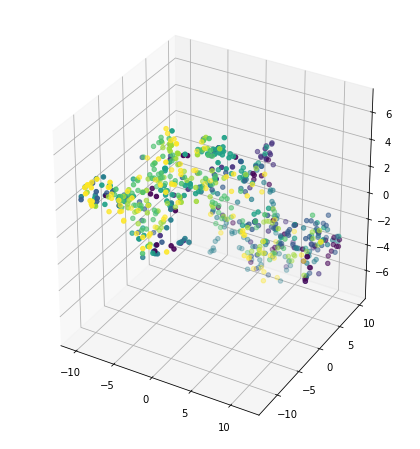

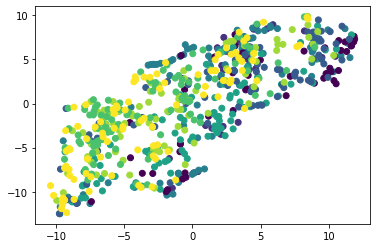

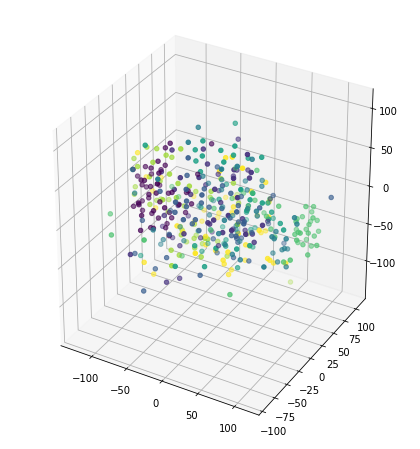

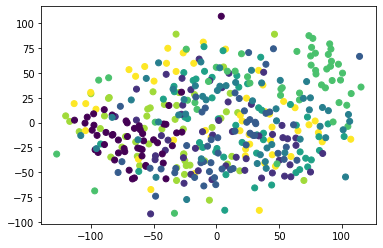

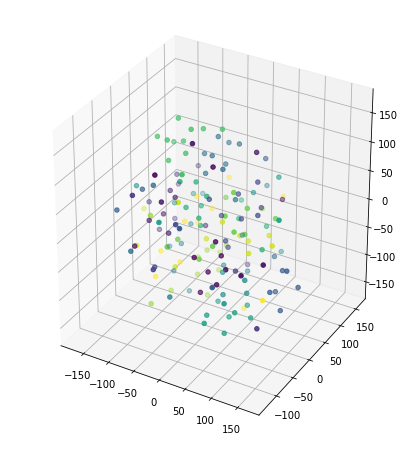

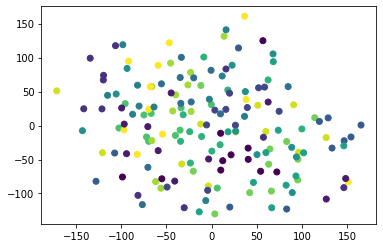

In [297]:
# Compute TSNE for different features and create a scatter plot

def plot_TSNE(X,y):
    k = 3 # Number of components in TSNE
    tsne = TSNE(n_components=k)
    X_TSNE = tsne.fit_transform(X)
    # Plot the representation in 2d/3d
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=y)
    plt.show()
    ax = fig.add_subplot(122)
    plt.scatter(X_TSNE[:,0],X_TSNE[:,1],c=y)
for i in range(3):
    X_k = get_pca(X[i],3)
    plot_TSNE(X_k,y[i])


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN
ANS:- Each  image  is  classified  by  a majority vote of its neighbours. We assign the majority class label among its K neighburs.


4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.
ANS:- We classify the test images using KNN and calculate the test accuracy
_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [248]:
class FaceVerification():
    def __init__(self,n):
        self.classifier = KNeighborsClassifier(n_neighbors=n)
        self.n = n
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        pred = self.classifier.predict(X)
        verfication_results = (class_id==pred)
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classifier.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        pred = self.classifier.predict(X_validate)
        acc = accuracy_score(y_validate,pred)
        conf_matrix = confusion_matrix(y_validate,pred)
        f1 = f1_score(y_validate,pred,average='weighted')
        return acc,conf_matrix,f1

In [249]:
# Create a train and validation split and show your results 
features = ["PCA","Kernel PCA","LDA","Kernel LDA","VGG features","RESNET features"]
def get_table_KNN(ind):
    class_error = []
    accuracy = []
    score = []
    con_matrix = []
    red_space = []
    for j in range(6):
        cls = FaceVerification(7)
        X_train,X_val,y_train,y_val = get_features(ind,j)
        cls.train(X_train,y_train)
        acc,cm,f1 = cls.validate(X_val,y_val)
        con_matrix.append(cm)
        score.append(f1)
        accuracy.append(acc*100)
        class_error.append((1-acc)*100)
        red_space.append(X_train.shape[1])
    return accuracy,red_space,class_error,score,con_matrix[np.argmax(np.array(accuracy))]

In [250]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 

# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
accuracy,red_space,class_error,score,con_matrix = get_table_KNN(0)
conf_matrix.append(con_matrix[np.argmax(accuracy)])
tab = {"Features":features,"Reduced Dimension Space": red_space, "verification_error": class_error,"Accuracy":accuracy,"f1-score":score}
df = pd.DataFrame(tab)
df
# Print the table. (You can use Pandas)

,Features,Reduced Dimension Space,verification_error,Accuracy,f1-score
0,PCA,40,51.111111,48.888889,0.479554
1,Kernel PCA,40,51.851852,48.148148,0.489945
2,LDA,7,64.444444,35.555556,0.342241
3,Kernel LDA,7,84.444444,15.555556,0.142279
4,VGG features,4096,34.074074,65.925926,0.667161
5,RESNET features,2048,2.222222,97.777778,0.977901


In [251]:
accuracy,red_space,class_error,score,con_matrix = get_table_KNN(1)
conf_matrix.append(con_matrix[np.argmax(accuracy)])
tab = {"Features":features,"Reduced Dimension Space": red_space, "verification_error": class_error,"Accuracy":accuracy,"f1-score":score}
df = pd.DataFrame(tab)
df

,Features,Reduced Dimension Space,verification_error,Accuracy,f1-score
0,PCA,40,31.25,68.75,0.678434
1,Kernel PCA,40,36.25,63.75,0.624975
2,LDA,7,25.00,75.00,0.751039
3,Kernel LDA,7,45.00,55.00,0.536717
4,VGG features,4096,10.00,90.00,0.902523
5,RESNET features,2048,8.75,91.25,0.914233


In [252]:
accuracy,red_space,class_error,score,con_matrix = get_table_KNN(2)
conf_matrix.append(con_matrix[np.argmax(accuracy)])
tab = {"Features":features,"Reduced Dimension Space": red_space, "verification_error": class_error,"Accuracy":accuracy,"f1-score":score}
df = pd.DataFrame(tab)
df

,Features,Reduced Dimension Space,verification_error,Accuracy,f1-score
0,PCA,40,24.242424,75.757576,0.75325
1,Kernel PCA,40,6.060606,93.939394,0.94228
2,LDA,14,0.000000,100.000000,1.00000
3,Kernel LDA,14,0.000000,100.000000,1.00000
4,VGG features,4096,45.454545,54.545455,0.52785
5,RESNET features,2048,0.000000,100.000000,1.00000


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [269]:
# Load data
# CARTOON VS REAL
X1= X[0]
X2 = X[1]
y1 = np.zeros(y1.size)
y2 = np.ones(y2.size)

#shuffle = np.random.permutation(y.size)
features_x = []
X_1 = np.concatenate((X1,X2),axis=0)
y_1 = np.concatenate((y1,y2),axis=0)


In [270]:
# Define your features
def get_features_cfw(i):
    dirpath1 = './dataset/IIIT-CFW/'
    dirpath2 = './dataset/IMFDB/'
    if i==0:
        ft = get_pca(X_1,50)
        return split(ft,y_1)
    elif i==1:
        ft = get_kernel_pca(X_1,50)
        return split(ft,y_1)
    elif i==2:
        X_train,X_val,y_train,y_val = split(X_1,y_1)
        ft,ft1 = get_lda(X_train,y_train,X_val,50)
        return ft,ft1,y_train,y_val
    elif i==3:
        X_train,X_val,y_train,y_val = split(X_1,y_1)
        ft,ft1 = get_kernel_lda(X_train,y_train,X_val,50)
        return ft,ft1,y_train,y_val
    elif i==4:
        ft1 = get_vgg_features(dirpath1)
        ft2 = get_vgg_features(dirpath2)
        ft = np.concatenate((ft1,ft2),axis=0)
        return split(ft,y_1)
    elif i==5:
        ft1 = get_resnet_features(dirpath1)
        ft2 = get_resnet_features(dirpath2)
        ft = np.concatenate((ft1,ft2),axis=0)
        return split(ft,y_1)
    return i,i,i,i

def get_table_cfw():
    models = ["MLP","Logistic_regression","SVM","Decision_tree"]
    class_error = []
    accuracy = []
    score = []
    con_matrix = []
    red_space = []
    cls_model = []
    for j in range(6):
        best_acc, best_con_matrix, best_score, mod = 0, 0, 0, 0
        for i in range(4):
            cls = Classifier(models[i])
            X_train,X_val,y_train,y_val = get_features_cfw(j)
            cls.train(X_train,y_train)
            cm,acc,rep,f1 = cls.validate(X_val,y_val)
            if best_acc < acc:
                best_acc,best_con_matrix,best_score,mod = acc,cm,f1,models[i]
        con_matrix.append(best_con_matrix)
        score.append(best_score)
        accuracy.append(best_acc*100)
        class_error.append((1-best_acc)*100)
        red_space.append(X_train.shape[1])
        cls_model.append(mod)
        
    return accuracy,class_error,score,red_space,cls_model,con_matrix


In [271]:
# Create your classifier
conf_matrix = []
features = ["PCA","Kernel PCA","LDA","Kernel LDA","VGG features","RESNET features"]
accuracy,class_error,score,red_space,cls_model,con_matrix = get_table_cfw()
conf_matrix.append(con_matrix[np.argmax(accuracy)])
tab = {"Features":features,"Best_model":cls_model,"Reduced Dimension Space": red_space, "Classification_error": class_error,"Accuracy":accuracy,"f1-score":score}
df = pd.DataFrame(tab)
df
# Validate your classifier

,Features,Best_model,Reduced Dimension Space,Classification_error,Accuracy,f1-score
0,PCA,MLP,50,1.395349,98.604651,0.986031
1,Kernel PCA,MLP,50,2.325581,97.674419,0.976646
2,LDA,Decision_tree,1,13.953488,86.046512,0.862454
3,Kernel LDA,Decision_tree,1,23.720930,76.279070,0.755404
4,VGG features,MLP,4096,0.000000,100.000000,1.000000
5,RESNET features,MLP,2048,0.000000,100.000000,1.000000


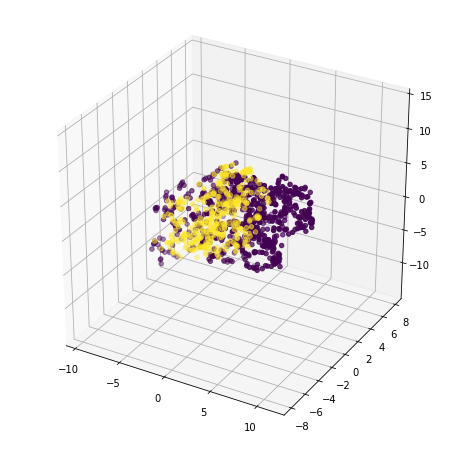

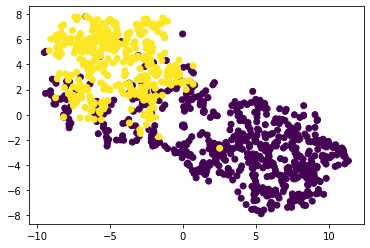

In [272]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  
X_k = get_pca(X_1,3)
plot_TSNE(X_k,y_1)

Some wrongly classified images with their original class


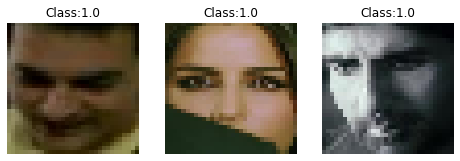

Some correctly classified images


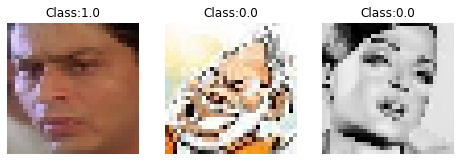

In [278]:
# Show quantitative results such as examples of correct prediction and wrong prediction
clf = Classifier("MLP")
X_train,X_val,y_train,y_val = split(X_1,y_1)
clf.train(X_train,y_train)
pred = clf.classify(X_val)
ind = np.where(pred!=y_val)
if len(ind)>3:
    ind = ind[:3]
X_val = X_val.reshape((X_val.shape[0],H1,W1,C))
print("Some wrongly classified images with their original class")
disply_images(X_val[ind],y_val[ind], row=1,col=3)
ind = np.where(pred==y_val)
if len(ind)>3:
    ind = ind[:3]
print("Some correctly classified images")
disply_images(X_val[ind],y_val[ind], row=1,col=3)